In [2]:
#Import Libraries
import tensorflow as tf
tf.enable_eager_execution()

from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.python.keras.models import Model
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#pretraind model VGG19
model = VGG19(
    include_top = False,
    weights = 'imagenet'
)

model.trainable = False
model.summary()

80142336/80134624 [==============================] - 273s 3us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
____________________________________________________________

---------------------------------------------------------------------------------------------
## Image Processing and Display

In [4]:
def load_and_process_image(image_path):
    img = load_img(image_path)
    img = img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis = 0)
    return img

def deprocess(x):
    # perform the inverse of the preprocessiing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def display_image(image):
    if len(image.shape) == 4:
        img = np.squeeze(image, axis = 0)

    img = deprocess(img)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    return

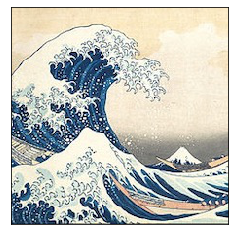

In [5]:
img = load_and_process_image('style.jpg')
display_image(img)

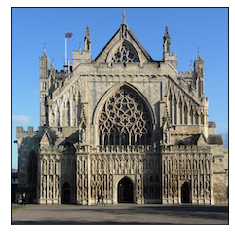

In [6]:
img = load_and_process_image('content.jpg')
display_image(img)

---------------------------------------------------------------------------------------
## Content and Style Models

In [7]:
style_layers = [
    'block1_conv1', 
    'block3_conv1', 
    'block5_conv1'
]

content_layer = 'block5_conv2'

# intermediate models
content_model = Model(
    inputs = model.input, 
    outputs = model.get_layer(content_layer).output
)

style_models = [Model(inputs = model.input, 
                      outputs = model.get_layer(layer).output) for layer in style_layers]

## Content Cost

In [8]:
# Content Cost
def content_cost(content, generated):
    a_C = content_model(content)
    a_G = content_model(generated)
    cost = tf.reduce_mean(tf.square(a_C - a_G))
    return cost

## Style Cost

In [10]:
lam = 1. / len(style_models) 

#gram matrix
def gram_matrix(A):
    channels = int(A.shape[-1])
    a = tf.reshape(A, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a = True)
    return gram / tf.cast(n, tf.float32)


def style_cost(style, generated):
    J_style = 0
    
    for style_model in style_models:
        a_S = style_model(style)
        a_G = style_model(generated)
        GS = gram_matrix(a_S)
        GG = gram_matrix(a_G)
        current_cost = tf.reduce_mean(tf.square(GS - GG))
        J_style += current_cost * lam
    
    return J_style

## Training Loop

In [15]:
generated_images = []

def training_loop(content_path, style_path, iterations = 22, a = 10., b = 20.):
    # initialise
    content = load_and_process_image(content_path)
    style = load_and_process_image(style_path)
    generated = tf.contrib.eager.Variable(content, dtype = tf.float32)
    
    opt = tf.train.AdamOptimizer(learning_rate = 7.)
    
    best_cost = 1e12+0.1
    best_image = None
    
    start_time = time.time()
    
    for i in range(iterations):
        
        with tf.GradientTape() as tape:
            J_content = content_cost(content, generated)
            J_style = style_cost(style, generated)
            J_total = a * J_content + b * J_style
        
        grads = tape.gradient(J_total, generated)
        opt.apply_gradients([(grads, generated)])
        
        if J_total < best_cost:
            best_cost = J_total
            best_image = generated.numpy()
        
        if i % int(iterations/10) == 0:
            time_taken = time.time() - start_time
            print('Cost at {}: {}. Time elapsed: {}'.format(i, J_total, time_taken))
            generated_images.append(generated.numpy())
        
    return best_image

In [16]:
final = training_loop('content.jpg','style.jpg')

Cost at 0: 13733988352.0. Time elapsed: 7.609477758407593
Cost at 2: 5336754688.0. Time elapsed: 26.24606418609619
Cost at 4: 3317568512.0. Time elapsed: 44.73300242424011
Cost at 6: 2499369472.0. Time elapsed: 63.922927141189575
Cost at 8: 2034576768.0. Time elapsed: 82.59643292427063
Cost at 10: 1641366016.0. Time elapsed: 102.9673981666565
Cost at 12: 1319857920.0. Time elapsed: 122.40761280059814
Cost at 14: 1100589696.0. Time elapsed: 141.63068318367004
Cost at 16: 955178048.0. Time elapsed: 162.26576495170593
Cost at 18: 836839296.0. Time elapsed: 181.0110466480255
Cost at 20: 739674240.0. Time elapsed: 201.70186066627502


## Results

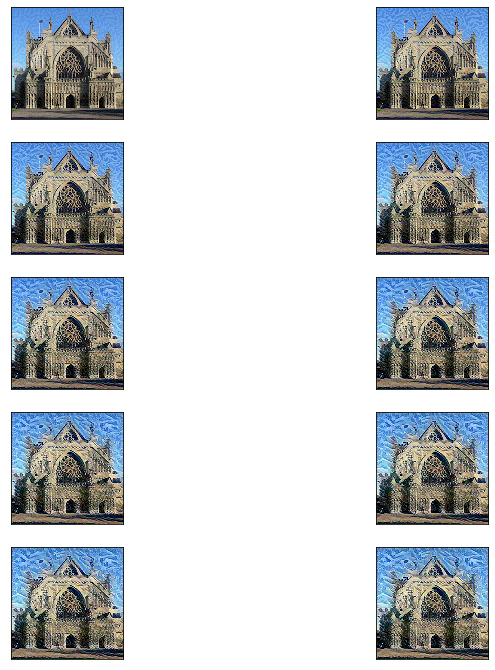

In [17]:
plt.figure(figsize = (12, 12))

for i in range(10):
    plt.subplot(5, 2, i + 1)
    display_image(generated_images[i])
plt.show()

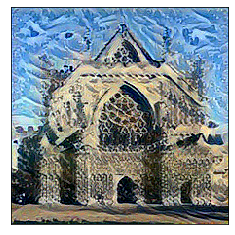

In [18]:
display_image(final)